# Hierarchical Bayesian Inference of Normal Means #

This notebook is based on Chapter 5.4, 5.5 and 5.6 of 'Bayesian Data Analysis' (Gelman et. al, 3rd Edition).

Suppose we have $J$ observations $\bar{y}_{\cdot j} \mid \theta_j \sim \text{N}(\theta_j, \sigma_j^2)$, conditionally independent of each other given its parameters.  The variance parameter $\sigma_j^2$ is assumed to be known, and the mean parameter $\theta_j$'s are independently sampled from prior $\text{N}(\mu, \tau^2)$.  Finally, we assign uniform hyperprior distribution for $\mu$ given $\tau$:
$$
p(\mu,\tau) = p(\mu \mid \tau) p(\tau) \propto p(\tau).
$$

In [1]:
# prepare inline pylab
% pylab inline

Populating the interactive namespace from numpy and matplotlib


## Parallel Experiments in Eight Schools (BDA 5.5) ##

Please refer to the corresponding chapter of the book for description of the data.  I typed the data myself:

In [2]:
# load hand-typed data
from pandas import *
import numpy as np
school_data = DataFrame(data={'means':[28,8,-3,7,-1,1,18,12],'serrs':[15,10,16,11,9,11,10,18]},
                        index=['A','B','C','D','E','F','G','H'])

In [3]:
# the data looks like this
school_data

means  serrs
A     28     15
B      8     10
C     -3     16
D      7     11
E     -1      9
F      1     11
G     18     10
H     12     18

Since mean parameters are conjugate to each other, only tricky part is the standard deviation parameter $\tau$ for group means.  We marginalize out all other variables to make inference on $\tau$.

In [3]:
# define marginal log posterior function of tau
def log_posterior_tau_helper(tau, means, serrs, log_prior=lambda tau: 0):
    '''
    computes log marginal hyperparameter density of tau
    '''
    ret = log_prior(tau)
    marginal_variances = serrs ** 2 + tau ** 2
    total_variance = 1.0/np.sum(1.0/marginal_variances)  #V_\mu
    
    # precision weighted average L4 Step1
    mu_hat = np.sum((1.0/marginal_variances) * means) / \
            np.sum(1.0/marginal_variances)
        
    ret += 0.5 * log(total_variance)
    ret -= 0.5 * np.sum(np.log(marginal_variances))
    ret -= 0.5 * np.sum(((means - mu_hat) ** 2)/marginal_variances)
    return ret
# vectorize the function for convenience
log_posterior_tau = \
    np.vectorize(log_posterior_tau_helper, otypes=[np.float], excluded=[1,2,3])

Now let us reproduce Figure 5.5, which draws marginal posterior density $p(\tau \mid y)$.

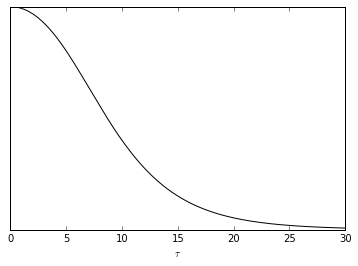

In [6]:
import pylab as pl
# grid points to evaluate evaluate density function
tau_min = 0; tau_max = 30; tau_grid_num = 1000
tau_knots = np.linspace(tau_min, tau_max, tau_grid_num)
lop_posterior_tau_densities = \
    log_posterior_tau(tau_knots, school_data.means, 
                      school_data.serrs, log_prior=lambda tau: 0)
# when calculating densities, it is numerically more stable to 
# first compute in log space, subtract the maximum, and then exponentiate
posterior_tau_densities = \
        np.exp(lop_posterior_tau_densities - np.max(lop_posterior_tau_densities))
#np.exp(log_posterior_tau_densities - log_posterior_tau_densities.max())
pl.plot(tau_knots, posterior_tau_densities, color='k', linestyle='-', linewidth=1)
pl.axes().set_xlabel(r'$\tau$')
# the y-axis of unnormalized posterior means nothing, so rather hide the scale
pl.axes().get_yaxis().set_visible(False)

This plot indicates that values of $\tau$ near zero are most plausible, but large values such as 10 or 15 are still quite likely.

Now, we study the change of $\mathbb{E}[\theta_j \mid \tau]$'s and $\text{sd}[\theta_j \mid \tau]$'s as a function of $\tau$.  This can be done by marginalizing out $\mu$ from the conditional distribution $\theta_j \mid \mu,\tau,y$.

In [13]:
def mean_posterior_given_tau(tau, means, serrs):
    assert(len(means) == len(serrs))
    marginal_variances = serrs ** 2 + tau ** 2
    total_variance = 1.0/np.sum(1.0/marginal_variances)
    # precision weighted average
    mu_hat = np.sum((1.0/marginal_variances) * means) / \
            np.sum(1.0/marginal_variances)               #mu_hat
    if tau == 0:
        return np.repeat(mu_hat, len(means))
    return ((1.0/(serrs ** 2)) * means + 1.0/(tau ** 2) * mu_hat) / (1.0/(serrs ** 2) + 1.0/(tau ** 2))

def sd_posterior_given_tau(tau, serrs):
    marginal_variances = serrs ** 2 + tau ** 2
    total_variance = 1.0/np.sum(1.0/marginal_variances)  #V_u
    individual_variances = (((serrs ** 2)/(serrs ** 2 + tau ** 2)) ** 2) * total_variance
    if tau == 0:
        return np.sqrt(individual_variances)
    return np.sqrt(individual_variances + 1.0 / (1.0/(serrs ** 2) + 1.0/(tau ** 2)))

mean_posterior_given_taus = \
    np.vectorize(mean_posterior_given_tau, otypes=[np.ndarray], excluded=[1,2])
tau_conditional_means = \
        pandas.DataFrame.from_records(mean_posterior_given_taus(tau_knots, school_data.means, school_data.serrs),
                                      index = tau_knots, columns=school_data.index)
    
sd_posterior_given_taus = \
    np.vectorize(sd_posterior_given_tau, otypes=[np.ndarray], excluded=[1])
tau_conditional_sds = \
        pandas.DataFrame.from_records(sd_posterior_given_taus(tau_knots, school_data.serrs),
                                      index = tau_knots, columns=school_data.index)


array([ 0.9486833 ,  1.66410059,  2.12132034])

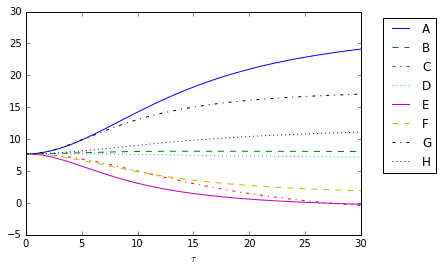

In [8]:
# I was not able to put inline labels in Python. 
# this page contains an example code for it: http://stackoverflow.com/questions/16992038/inline-labels-in-matplotlib
tau_conditional_means.plot(style=['-','--','-.',':','-','--','-.',':'])
pl.legend(bbox_to_anchor=(1.05, 1), loc=2)
pl.ylim(-5,30)
pl.axes().set_xlabel(r'$\tau$')
pl.show()

When $\tau = 0$, all group means are treated to be the same, while as $\tau \rightarrow \infty$ they converge to individual MLEs.

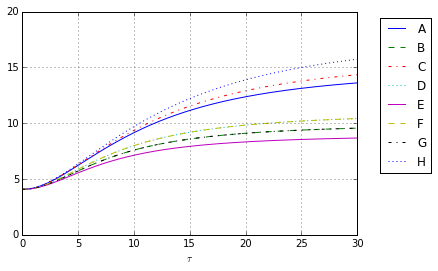

In [8]:
tau_conditional_sds.plot(style=['-','--','-.',':','-','--','-.',':'])
pl.legend(bbox_to_anchor=(1.05, 1), loc=2)
pl.ylim(0,20)
pl.axes().set_xlabel(r'$\tau$')
pl.show()

Naturally, larger $\tau$ means higher uncertainty in estimates.  

Now, let us sample parameters from the joint posterior distribution.

In [9]:
# seed the RNG
np.random.seed(13531)
sample_num = 200


#Step1: first sample tau's
tau_probs = posterior_tau_densities / posterior_tau_densities.sum()
samples_tau = np.random.choice(tau_knots, sample_num, p=tau_probs)


#Step2: now sample mu conditioned on tau
def sample_means_from_tau(tau, means, serrs, include_mu=False):
    if isinf(tau):
        if include_mu:
            raise ValueError("mu is not well defined when tau is infinity")
        else:
            return np.random.normal(loc=means, scale=serrs)


    
    # precision weighted average mu_hat
    mu_hat = np.sum((1.0/marginal_variances) * means) / \
            np.sum(1.0/marginal_variances)
    
    #variance V_u      
    marginal_variances = serrs ** 2 + tau ** 2
    total_variance = 1.0/np.sum(1.0/marginal_variances)            
            
    #sample from Step3 in L4 slide page 30    
    sample_mu = np.random.normal(loc=mu_hat, scale=np.sqrt(total_variance))
    if tau == 0:
        if include_mu:
            return np.repeat(sample_mu, len(means) + 1)
        else:
            return np.repeat(sample_mu, len(means))
    
    #Step3: Sample \theta_j
    conditional_means = \
        ((1.0/(serrs ** 2)) * means + 1.0/(tau ** 2) * sample_mu) /\
        (1.0/(serrs ** 2) + 1.0/(tau ** 2))
    conditional_scales = np.sqrt(1.0 / (1.0/(serrs ** 2) + 1.0/(tau ** 2)))
    if include_mu == True:
        return np.concatenate(([sample_mu],
                               np.random.normal(loc=conditional_means,
                                                scale=conditional_scales)))
    else:
        return np.random.normal(loc=conditional_means,
                                scale=conditional_scales)
        
sample_means_from_taus = \
        np.vectorize(sample_means_from_tau, otypes=[np.ndarray], excluded=[1,2,3])

samples_df = DataFrame.from_records(sample_means_from_taus(samples_tau, school_data.means, school_data.serrs),
                                    columns=school_data.index)

Now that we have posterior samples, we can reproduce Table 5.3. which shows quantiles of posterior samples:

In [10]:
samples_df.quantile([0.025,0.25,0.5,0.75,0.975]).transpose().apply(np.round)

0.025  0.250  0.500  0.750  0.975
A     -4      6     10     15     27
B     -4      3      7     12     20
C    -12      2      7     11     19
D     -6      5      8     12     19
E    -10      2      6      9     17
F    -11      3      7     10     19
G     -0      7     10     14     29
H     -9      4      8     13     26

Lower and upper quantiles deviate a bit from the book, but this is probably due to small sample size (200).

Figure 5.8 (a) reproduced below shows posterior samples for the effect in school A.

(-20, 60)

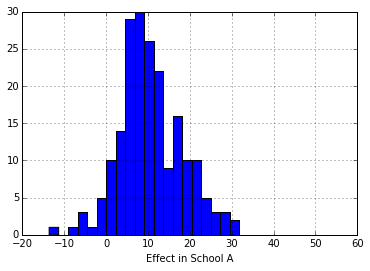

In [11]:
samples_df['A'].hist(bins=20)
pl.axes().set_xlabel(r'Effect in School A')
pl.xlim(-20,60)

Figure 5.8 (b) reproduced below shows posterior samples of the largest effect.

(-20, 60)

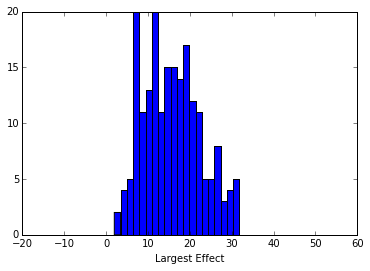

In [12]:
pl.hist(samples_df.max(axis=1), bins=20)
pl.axes().set_xlabel(r'Largest Effect')
pl.xlim(-20,60)

$\text{Pr}(\max\{ \theta_j \} > 28.4 \mid y)$ can be calculated as:

In [13]:
np.mean(samples_df.max(axis=1) > 28.4)

0.055

Since the probability is small, the accuracy with only 200 samples is quite poor.

We can also compute $\text{Pr}(\theta_1 > \theta_3 \mid y)$:

In [14]:
np.mean(samples_df['A'] > samples_df['C'])

0.61499999999999999

## Model Checking (BDA 6.5) ##

To check the model fit, we sample predictive data from posterior distribution and then measure its test statistics.

In [15]:
samples_df.head(20)

A          B          C          D          E          F  \
0    7.716427   9.991674   0.866800  14.593627  -3.965988  20.090856   
1    0.502421   0.895309   6.927228   7.559977   6.383656   5.732490   
2    8.107001   8.818356   9.584960  11.167918   9.818180   9.268566   
3    9.534934   0.192279   4.933994   0.482355  -5.051685  10.671843   
4   18.022723   6.934803   8.512424  10.223763  -0.429200  -6.964528   
5    6.633026   8.278496   4.938248   9.555146   3.424603   5.327314   
6   17.482265  13.638312   9.628664  17.087535  -3.717156   8.630172   
7   24.679603   3.786353 -13.655367   1.635514 -16.328680 -11.222549   
8    5.607194   7.493853   6.257384   7.402898   4.467476   6.417064   
9    1.510968   4.395459   0.566861   9.807944  20.997995  -1.304262   
10  12.992872  12.435256  13.049840  12.809142  12.259121  13.060207   
11   3.284644  14.320452   5.336783   6.618106  -0.524970  -3.601224   
12   7.377929   6.828941   7.854961   9.082657   7.013176   7.083400   
13   7.581249   7.036055   7.733224   7.954896   7.830516   7.242541   
14  13.330399  15.175647  17.757907  16.201320  19.855363  19.631324   
15   0.630096   7.182227   3.427380  -0.388352   8.674099   3.847556   
16  19.841116   9.744172  16.355059  10.245631   8.982854  10.994532   
17   5.840998   4.386583   7.317891   6.027662   4.462467   2.977552   
18   6.137699   7.815479   6.554743   7.187624   8.016367   7.061611   
19   8.870123  10.109709  12.002920   8.231484   6.697967  11.152029   

            G          H  
0   12.917670   1.829894  
1    1.512876  11.911749  
2   13.150036  11.544678  
3   22.620177   2.510405  
4    9.610435   6.192576  
5    6.755715   6.239499  
6   19.108511  -1.979328  
7   17.283001  -7.251771  
8    6.110007   7.335749  
9    5.611880  13.863666  
10  13.397225  12.888974  
11   7.833326  -3.732031  
12  10.005125   8.248841  
13   8.061920   7.625156  
14  20.120813  19.342776  
15   8.419566  19.522541  
16  18.775112  16.951828  
17   4.499661   5.723083  
18   5.763623   5.859263  
19   7.715419   8.036580

In [16]:
posterior_data_list = []
for row_index, row in samples_df.iterrows():
    posterior_data_list.append( np.random.normal(loc=row, scale=school_data.serrs) )
posterior_data_df = DataFrame.from_records(posterior_data_list,
                                           columns=school_data.index)

p-value: 0.56


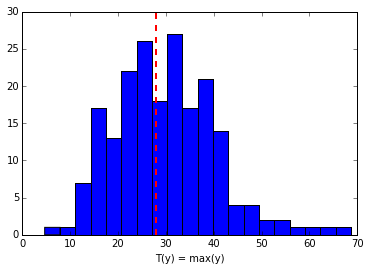

In [17]:
pl.hist(posterior_data_df.max(axis=1), bins=20)
pl.axes().set_xlabel(r'T(y) = max(y)')
pl.axvline(school_data.means.max(), color='r', linestyle='dashed', linewidth=2)
print "p-value: %.2f" % (np.sum(posterior_data_df.max(axis=1) > school_data.means.max())/float(len(posterior_data_df)))

p-value: 0.23


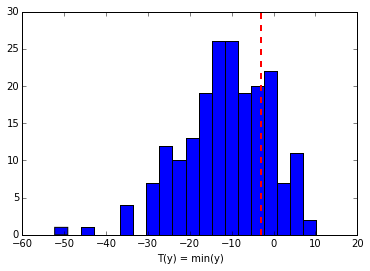

In [18]:
pl.hist(posterior_data_df.min(axis=1), bins=20)
pl.axes().set_xlabel(r'T(y) = min(y)')
pl.axvline(school_data.means.min(), color='r', linestyle='dashed', linewidth=2)
print "p-value: %.2f" % (np.sum(posterior_data_df.min(axis=1) > school_data.means.min())/float(len(posterior_data_df)))

p-value: 0.51


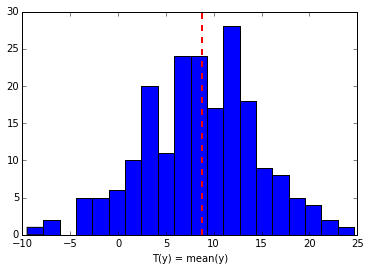

In [19]:
pl.hist(posterior_data_df.mean(axis=1), bins=20)
pl.axes().set_xlabel(r'T(y) = mean(y)')
pl.axvline(school_data.means.mean(), color='r', linestyle='dashed', linewidth=2)
print "p-value: %.2f" % (np.sum(posterior_data_df.mean(axis=1) > school_data.means.mean())/float(len(posterior_data_df)))

p-value: 0.80


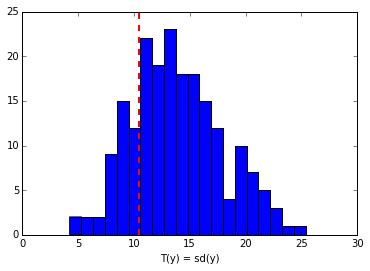

In [20]:
pl.hist(posterior_data_df.std(axis=1), bins=20)
pl.axes().set_xlabel(r'T(y) = sd(y)')
pl.axvline(school_data.means.std(), color='r', linestyle='dashed', linewidth=2)
print "p-value: %.2f" % (np.sum(posterior_data_df.std(axis=1) > school_data.means.std())/float(len(posterior_data_df)))

Surprisingly, these p-values are too close to what we have in the book, considering the small data size!

## Model Comparison based on predictive performance (BDA 7.3) ##

(Sorry for extreme low quality code with a lot of redundancies here; I quickly began tosmell something bad, but was too lazy to go back.)

In [21]:
from scipy.stats import *
# computing AIC
# first, compute MLE estimate
marginal_variances = school_data.serrs ** 2
total_variance = 1.0/np.sum(1.0/marginal_variances)
# precision weighted average
mle_complete_pooling = np.sum((1.0/marginal_variances) * school_data.means) / np.sum(1.0/marginal_variances)
mle_lpd_complete_pooling = norm.logpdf(school_data.means, loc=mle_complete_pooling, scale=school_data.serrs).sum()
mle_lpd_no_pooling = norm.logpdf(school_data.means, loc=school_data.means, scale=school_data.serrs).sum()
print "AIC for complete pooling: %.1f" % (-2 * mle_lpd_complete_pooling + 1 * 2)
print "AIC for no pooling: %.1f" % (-2 * mle_lpd_no_pooling + 8 * 2)

AIC for complete pooling: 61.3
AIC for no pooling: 70.6


In [22]:
# computing DIC
# here we increase sample number to improve the precision
sample_num = 2000
# sample 
complete_pooling_samples_df = DataFrame.from_records(sample_means_from_taus(np.repeat(0,sample_num), school_data.means, school_data.serrs),
                                                     columns=school_data.index)
no_pooling_samples_df = DataFrame.from_records(sample_means_from_taus(np.repeat(float('inf'),sample_num), school_data.means, school_data.serrs),
                                               columns=school_data.index)

samples_tau = np.random.choice(tau_knots, sample_num, p=tau_probs)
hierarchical_samples_df = DataFrame.from_records(sample_means_from_taus(samples_tau, school_data.means, school_data.serrs),
                                                 columns=school_data.index)
# first, compute expected mean from posterior distribution
pmean_no_pooling = no_pooling_samples_df.mean()
pmean_complete_pooling = complete_pooling_samples_df.mean()
pmean_hierarchical = hierarchical_samples_df.mean()

pmean_lpd_no_pooling = norm.logpdf(school_data.means, loc=pmean_no_pooling, scale=school_data.serrs).sum()
pmean_lpd_complete_pooling = norm.logpdf(school_data.means, loc=pmean_complete_pooling, scale=school_data.serrs).sum()
pmean_lpd_hierarchical = norm.logpdf(school_data.means, loc=pmean_hierarchical, scale=school_data.serrs).sum()

print "-2lpd with no pooling: %.1f" % (-2 * pmean_lpd_no_pooling)
print "-2lpd with complete pooling: %.1f" % (-2 * pmean_lpd_complete_pooling)
print "-2lpd with hierarchical pooling: %.1f" % (-2 * pmean_lpd_hierarchical)

pdic_no_pooling = 2 * (pmean_lpd_no_pooling - \
    no_pooling_samples_df.apply(lambda x: norm.logpdf(school_data.means, loc=x, 
                                                      scale=school_data.serrs),
                                axis=1).sum(axis=1).mean())
pdic_complete_pooling = 2 * (pmean_lpd_complete_pooling - \
    complete_pooling_samples_df.apply(lambda x: norm.logpdf(school_data.means, loc=x, 
                                                            scale=school_data.serrs), 
                                      axis=1).sum(axis=1).mean())
pdic_hierarchical = 2 * (pmean_lpd_hierarchical - \
    hierarchical_samples_df.apply(lambda x: norm.logpdf(school_data.means, loc=x, 
                                                        scale=school_data.serrs), axis=1).sum(axis=1).mean())
print "p_DIC for no pooling: %.1f" % (pdic_no_pooling)
print "p_DIC for complete pooling: %.1f" % (pdic_complete_pooling)
print "p_DIC for hierarchical pooling: %.1f" % (pdic_hierarchical)

print "DIC for no pooling: %.1f" % (-2 * pmean_lpd_no_pooling + 2 * pdic_no_pooling)
print "DIC for complete pooling: %.1f" % (-2 * pmean_lpd_complete_pooling + 2 * pdic_complete_pooling)
print "DIC for hierarchical pooling: %.1f" % (-2 * pmean_lpd_hierarchical + 2 * pdic_hierarchical)

-2lpd with no pooling: 54.6
-2lpd with complete pooling: 59.3
-2lpd with hierarchical pooling: 57.5
p_DIC for no pooling: 8.0
p_DIC for complete pooling: 1.0
p_DIC for hierarchical pooling: 2.8
DIC for no pooling: 70.7
DIC for complete pooling: 61.3
DIC for hierarchical pooling: 63.0


In [23]:
# WAIC computation
# here I am not being careful in numerical precision; in principle I should've done these calculation in log space.
lppd_no_pooling = np.log(no_pooling_samples_df.apply(lambda x: norm.pdf(school_data.means, loc=x, 
                                                     scale=school_data.serrs), axis=1).mean(axis=0)).sum()
lppd_complete_pooling = np.log(complete_pooling_samples_df.apply(lambda x: norm.pdf(school_data.means, loc=x, 
                                                                 scale=school_data.serrs), axis=1).mean(axis=0)).sum()
lppd_hierarchical = np.log(hierarchical_samples_df.apply(lambda x: norm.pdf(school_data.means, loc=x, 
                                                                            scale=school_data.serrs), axis=1).mean(axis=0)).sum()
print "-2lppd with no pooling: %.1f" % (-2 * lppd_no_pooling)
print "-2lppd with complete pooling: %.1f" % (-2 * lppd_complete_pooling)
print "-2lppd with hierarchical pooling: %.1f" % (-2 * lppd_hierarchical)

pwaic_1_no_pooling = 2 * (lppd_no_pooling - 
                          no_pooling_samples_df.apply(lambda x: norm.logpdf(school_data.means, loc=x, 
                                                      scale=school_data.serrs), axis=1).mean(axis=0).sum())
pwaic_1_complete_pooling = 2 * (lppd_complete_pooling - 
                                complete_pooling_samples_df.apply(lambda x: norm.logpdf(school_data.means, loc=x, 
                                                                  scale=school_data.serrs), axis=1).mean(axis=0).sum())
pwaic_1_hierarchical = 2 * (lppd_hierarchical - 
                            hierarchical_samples_df.apply(lambda x: norm.logpdf(school_data.means, loc=x, 
                                                          scale=school_data.serrs), axis=1).mean(axis=0).sum())

print "p_WAIC1 with no pooling: %.1f" % (pwaic_1_no_pooling)
print "p_WAIC1 with complete pooling: %.1f" % (pwaic_1_complete_pooling)
print "p_WAIC1 with hierarchical pooling: %.1f" % (pwaic_1_hierarchical)

pwaic_2_no_pooling = no_pooling_samples_df.apply(lambda x: norm.logpdf(school_data.means, loc=x, 
                                                 scale=school_data.serrs), axis=1).var(axis=0).sum()
pwaic_2_complete_pooling = complete_pooling_samples_df.apply(lambda x: norm.logpdf(school_data.means, loc=x, 
                                                 scale=school_data.serrs), axis=1).var(axis=0).sum()
pwaic_2_hierarchical = hierarchical_samples_df.apply(lambda x: norm.logpdf(school_data.means, loc=x, 
                                                 scale=school_data.serrs), axis=1).var(axis=0).sum()

print "p_WAIC2 with no pooling: %.1f" % (pwaic_2_no_pooling)
print "p_WAIC2 with complete pooling: %.1f" % (pwaic_2_complete_pooling)
print "p_WAIC2 with hierarchical pooling: %.1f" % (pwaic_2_hierarchical)

print "WAIC with no pooling: %.1f" % (-2 * (lppd_no_pooling - pwaic_2_no_pooling))
print "WAIC with complete pooling: %.1f" % (-2 * (lppd_complete_pooling - pwaic_2_complete_pooling))
print "WAIC with hierarchical pooling: %.1f" % (-2 * (lppd_hierarchical - pwaic_2_hierarchical))

-2lppd with no pooling: 60.2
-2lppd with complete pooling: 59.8
-2lppd with hierarchical pooling: 59.2
p_WAIC1 with no pooling: 2.5
p_WAIC1 with complete pooling: 0.6
p_WAIC1 with hierarchical pooling: 1.0
p_WAIC2 with no pooling: 4.0
p_WAIC2 with complete pooling: 0.6
p_WAIC2 with hierarchical pooling: 1.3
WAIC with no pooling: 68.2
WAIC with complete pooling: 61.0
WAIC with hierarchical pooling: 61.9


LOOC is omitted since I am too lazy.

## Clinical Trials of Beta-blockers (BDA 5.6) ##

Here, we perform a meta-analysis which estimates the effect of beta-blockers from 22 clinical trials.  Since a lot of plots are omitted in this chapter of the book, this notebook might be interesting for someone who wanted to take a deeper look on this analysis. 

The data can be retrieved from the BDA book website:

In [24]:
blocker_data = read_csv("http://www.stat.columbia.edu/~gelman/book/data/meta.asc",
                        index_col='study', skiprows=3, delim_whitespace=True)

In [25]:
blocker_data

control.deaths  control.total  treated.deaths  treated.total
study                                                              
1                   3             39               3             38
2                  14            116               7            114
3                  11             93               5             69
4                 127           1520             102           1533
5                  27            365              28            355
6                   6             52               4             59
7                 152            939              98            945
8                  48            471              60            632
9                  37            282              25            278
10                188           1921             138           1916
11                 52            583              64            873
12                 47            266              45            263
13                 16            293               9            291
14                 45            883              57            858
15                 31            147              25            154
16                 38            213              33            207
17                 12            122              28            251
18                  6            154               8            151
19                  3            134               6            174
20                 40            218              32            209
21                 43            364              27            391
22                 39            674              22            680

Our estimand in this analysis is log odds ratio; this is estimated by empirical logit which sampling variance is estimated by eq (5.24).  We regard these values as means and variances of hierarchical normal means model.  First, let us calculate these values:

In [26]:
blocker_data['means'] = np.log(blocker_data['treated.deaths']\
                               /(blocker_data['treated.total']-blocker_data['treated.deaths'])) \
                        - np.log(blocker_data['control.deaths']\
                               /(blocker_data['control.total']-blocker_data['control.deaths']))
blocker_data['serrs'] = np.sqrt(1.0/blocker_data['treated.deaths'] + 
                                1.0/(blocker_data['treated.total'] - 1.0/blocker_data['treated.deaths']) + 
                                1.0/blocker_data['control.deaths'] + 
                                1.0/(blocker_data['control.total'] - 1.0/blocker_data['control.deaths']))                                

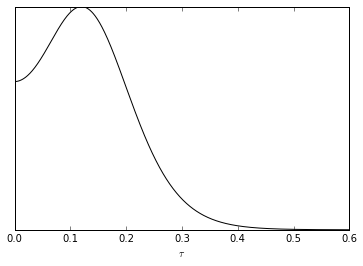

In [27]:
import pylab as pl
# grid points to evaluate evaluate density function
tau_min = 0; tau_max = 0.6; tau_grid_num = 1000
tau_knots = np.linspace(tau_min, tau_max, tau_grid_num)
lop_posterior_tau_densities = \
    log_posterior_tau(tau_knots, blocker_data.means, 
                      blocker_data.serrs, log_prior=lambda tau: 0)
# when calculating densities, it is numerically more stable to 
# first compute in log space, subtract the maximum, and then exponentiate
posterior_tau_densities = \
        np.exp(lop_posterior_tau_densities - np.max(lop_posterior_tau_densities))
#np.exp(log_posterior_tau_densities - log_posterior_tau_densities.max())
pl.plot(tau_knots, posterior_tau_densities, color='k', linestyle='-', linewidth=1)
pl.axes().set_xlabel(r'$\tau$')
# the y-axis of unnormalized posterior means nothing, so rather hide the scale
pl.axes().get_yaxis().set_visible(False)

As mentioned in the book, the marginal posterior density function of $\tau$ peaks at nonzero value, but still values around zero are quite plausible.

The plot below shows mean effects conditioned on $\tau$; combined with the information from plot above, this indicates that moderate amount of shrinkage in estimates are necessary.

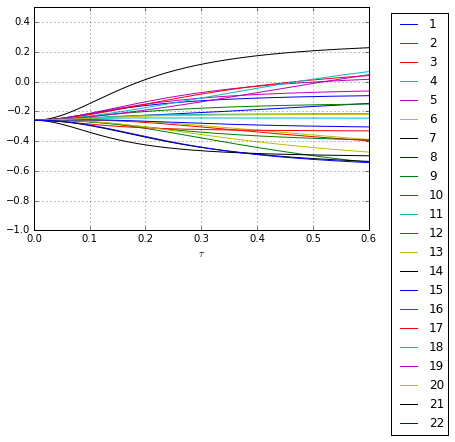

In [28]:
def mean_posterior_given_tau(tau, means, serrs):
    assert(len(means) == len(serrs))
    marginal_variances = serrs ** 2 + tau ** 2
    total_variance = 1.0/np.sum(1.0/marginal_variances)
    # precision weighted average
    mu_hat = np.sum((1.0/marginal_variances) * means) / \
            np.sum(1.0/marginal_variances)
    if tau == 0:
        return np.repeat(mu_hat, len(means))
    return ((1.0/(serrs ** 2)) * means + 1.0/(tau ** 2) * mu_hat) / (1.0/(serrs ** 2) + 1.0/(tau ** 2))

def sd_posterior_given_tau(tau, serrs):
    marginal_variances = serrs ** 2 + tau ** 2
    total_variance = 1.0/np.sum(1.0/marginal_variances)
    individual_variances = (((serrs ** 2)/(serrs ** 2 + tau ** 2)) ** 2) * total_variance
    if tau == 0:
        return np.sqrt(individual_variances)
    return np.sqrt(individual_variances + 1.0 / (1.0/(serrs ** 2) + 1.0/(tau ** 2)))

mean_posterior_given_taus = \
    np.vectorize(mean_posterior_given_tau, otypes=[np.ndarray], excluded=[1,2])
tau_conditional_means = \
        pandas.DataFrame.from_records(mean_posterior_given_taus(tau_knots, blocker_data.means, blocker_data.serrs),
                                      index=tau_knots, columns=blocker_data.index)
    
sd_posterior_given_taus = \
    np.vectorize(sd_posterior_given_tau, otypes=[np.ndarray], excluded=[1])
tau_conditional_sds = \
        pandas.DataFrame.from_records(sd_posterior_given_taus(tau_knots, blocker_data.serrs),
                                      index = tau_knots, columns=blocker_data.index)
# I was not able to put inline labels in Python. 
# this page contains an example code for it: http://stackoverflow.com/questions/16992038/inline-labels-in-matplotlib
tau_conditional_means.plot()
pl.legend(bbox_to_anchor=(1.05, 1), loc=2)
pl.ylim(-1,0.5)
pl.axes().set_xlabel(r'$\tau$')
pl.show()

Now let us sample from the joint posterior distribution.

In [29]:
# seed the RNG
np.random.seed(1353135)
sample_num = 5000
# first sample tau's
tau_probs = posterior_tau_densities / posterior_tau_densities.sum()
samples_tau = np.random.choice(tau_knots, sample_num, p=tau_probs)
# now sample mu conditioned on tau
samples_df = DataFrame.from_records(sample_means_from_taus(samples_tau, blocker_data.means, 
                                                           blocker_data.serrs, include_mu=True),
                                    columns=np.concatenate((['mu'],blocker_data.index)))

In [30]:
samples_columns_df = samples_df.drop('mu', 1)

Posterior quantiles in Table 5.4 can now be reproduced.

In [31]:
samples_columns_df.quantile([0.025,0.25,0.5,0.75,0.975]).transpose().apply(lambda x:np.round(x,decimals=2))

0.025  0.250  0.500  0.750  0.975
1   -0.58  -0.32  -0.25  -0.15   0.12
2   -0.64  -0.37  -0.28  -0.20  -0.01
3   -0.60  -0.35  -0.27  -0.19   0.03
4   -0.44  -0.31  -0.25  -0.19  -0.06
5   -0.43  -0.28  -0.21  -0.10   0.14
6   -0.61  -0.34  -0.26  -0.18   0.05
7   -0.61  -0.43  -0.35  -0.28  -0.17
8   -0.41  -0.28  -0.21  -0.13   0.10
9   -0.59  -0.36  -0.28  -0.21  -0.03
10  -0.48  -0.35  -0.29  -0.24  -0.13
11  -0.47  -0.31  -0.25  -0.17   0.01
12  -0.43  -0.29  -0.21  -0.12   0.10
13  -0.63  -0.36  -0.28  -0.20   0.01
14  -0.34  -0.22  -0.13   0.01   0.29
15  -0.55  -0.34  -0.26  -0.19   0.03
16  -0.47  -0.31  -0.23  -0.15   0.07
17  -0.47  -0.29  -0.21  -0.11   0.16
18  -0.49  -0.31  -0.23  -0.13   0.17
19  -0.52  -0.31  -0.23  -0.14   0.17
20  -0.50  -0.32  -0.25  -0.17   0.04
21  -0.65  -0.40  -0.31  -0.24  -0.09
22  -0.65  -0.40  -0.30  -0.23  -0.07

Now let us sample predicted effects.

In [32]:
samples_predicted_effect = np.zeros(len(samples_tau))
samples_predicted_effect[samples_tau > 0] = np.random.normal(loc=samples_df['mu'][samples_tau > 0],scale=samples_tau[samples_tau > 0])
samples_predicted_effect[samples_tau == 0] = samples_df['mu'][samples_tau == 0]

Now Table 5.5 can be reproduced.

In [33]:
DataFrame({'mean':samples_df['mu'], 
           'standard deviation':samples_tau, 
           'predicted_effect':samples_predicted_effect}).quantile([0.025,0.25,0.5,0.75,0.975]).transpose().apply(lambda x:np.round(x,decimals=2))

0.025  0.250  0.500  0.750  0.975
mean                -0.37  -0.29  -0.25  -0.21  -0.11
predicted_effect    -0.60  -0.33  -0.25  -0.16   0.14
standard deviation   0.01   0.07   0.13   0.18   0.31

Histograms of estimates, not shown in the book, are presented below.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10faf2bd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1120fea50>]], dtype=object)

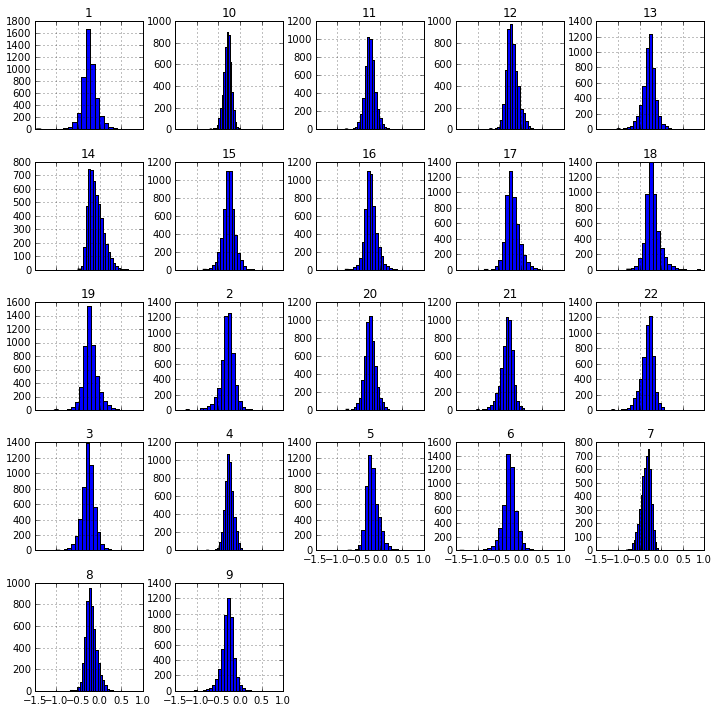

In [34]:
samples_columns_df.hist(figsize=(12,12),sharex=True, bins=20)

In [35]:
def mean_posterior_of_mean_given_tau(tau, means, serrs):
    assert(len(means) == len(serrs))
    marginal_variances = serrs ** 2 + tau ** 2
    total_variance = 1.0/np.sum(1.0/marginal_variances)
    # precision weighted average
    mu_hat = np.sum((1.0/marginal_variances) * means) / \
            np.sum(1.0/marginal_variances)
    return mu_hat

def sd_posterior_of_mean_given_tau(tau, means, serrs):
    assert(len(means) == len(serrs))
    marginal_variances = serrs ** 2 + tau ** 2
    total_variance = 1.0/np.sum(1.0/marginal_variances)
    return np.sqrt(total_variance)

mean_posterior_of_mean_given_taus = \
    np.vectorize(mean_posterior_of_mean_given_tau, otypes=[np.ndarray], excluded=[1,2])
sd_posterior_of_mean_given_taus = \
    np.vectorize(sd_posterior_of_mean_given_tau, otypes=[np.ndarray], excluded=[1,2])

Recall this was the posterior density of $\tau$:

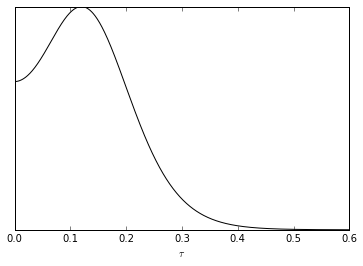

In [36]:
pl.plot(tau_knots, posterior_tau_densities, color='k', linestyle='-', linewidth=1)
pl.axes().set_xlabel(r'$\tau$')
# the y-axis of unnormalized posterior means nothing, so rather hide the scale
pl.axes().get_yaxis().set_visible(False)

Compared to the posterior quantile values of data, the conditional $\mu \mid \tau$ changes very little within most plausible region of $\tau$.

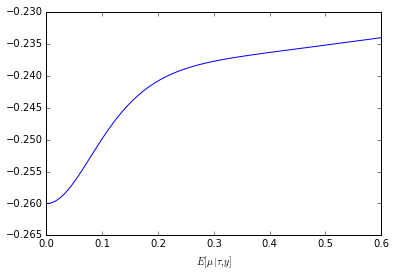

In [37]:
pl.plot(tau_knots, mean_posterior_of_mean_given_taus(tau_knots, blocker_data.means, blocker_data.serrs))
#pl.ylim((-0.6,0.1))
pl.axes().set_xlabel(r'$E[\mu \mid \tau,y]$')

However, the standard deviation changes greatly.

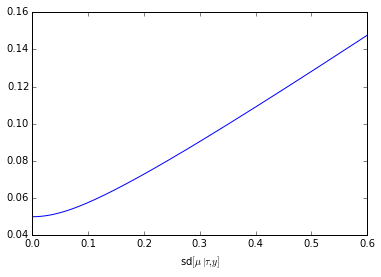

In [38]:
pl.plot(tau_knots, sd_posterior_of_mean_given_taus(tau_knots, blocker_data.means, blocker_data.serrs))
pl.axes().set_xlabel(r'sd$[\mu \mid \tau,y]$')

The book comments the value of $\text{sd}(\mu \mid \tau,y)$ at $\tau=0.13$:

In [39]:
sd_posterior_of_mean_given_tau(0.13, blocker_data.means, blocker_data.serrs)

0.061826519379229505

On the other hand, $\text{sd}(\mu \mid y)$, marginalized over $\tau$, can be computed from posterior samples as follows:

In [40]:
samples_df['mu'].std()

0.064647961365995488

Well this is a bit different from the value in the book, 0.071.  I wonder why...?